In [1]:
from synthetic_data_generator import create_synthetic_matrix, create_synthetic_data
from GNP import GNP, scale_A_by_spectral_radius
from ResGCN import ResGCN
from GMRES import GMRES
from scipy.sparse import csc_matrix, identity
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import math

# Hierarchichal training

In our case we can make problem gradually more difficult to solve, while keeping the the `A` matrix in exactly the same shape. This should allow us to use the same `ResGCN`

- First way is to increase the scale of the filter, as the bigger scacle the worse is the conditioning of the matrix. 
- Second is increasing the order of the filer `n`, which makes much more difficult to solve the problem
---

To start we have to generate sythetic problem of given size

In [2]:
Lx = 1000 # Size of domain in km
dxm = 2 # Mesh resolution in km
n2d = np.arange(0, Lx + 1, dxm, dtype="float32").shape[0]**2 # Number of mesh nodes

ss, ii, jj, tri, xcoord, ycoord = create_synthetic_matrix(Lx, dxm, False)
tt = create_synthetic_data(Lx, dxm)

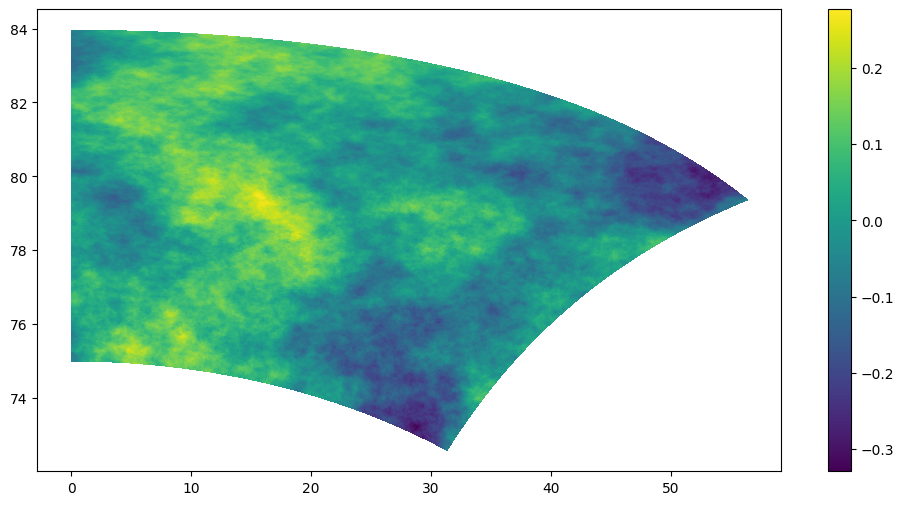

In [3]:
plt.rcParams['figure.figsize'] = [12, 6]
triang = mpl.tri.Triangulation(xcoord, ycoord, tri)

plt.tripcolor(triang, tt)
plt.colorbar()

Now lets define model parameters 

In [4]:
num_layers = 8              # number of layers in GNP
embed = 32                  # embedding dimension in GNP
hidden = 64                 # hidden dimension in MLPs in GNP
drop_rate = 0.05            # dropout rate in GNP
disable_scale_input = False # whether disable the scaling of inputs in GNP
dtype = torch.float64       # training precision for GNP
lr = 2e-3                   # learning rate in training GNP
weight_decay = 0.0          # weight decay in training GNP
training_data = 'x_mix'     # type of training data x
m = 80                      # Krylov subspace dimension for training data
batch_size = 4              # batch size in training GNP
grad_accu_steps = 1         # gradient accumulation steps in training GNP
epochs = 1000               # number of epochs in training GNP 

Now we need to create scales that we want to use

In [5]:
kc = 2 * math.pi / np.logspace(1, 3, 10) # 10 values from 10 to 1000 km

In [6]:
tt.shape

(251001,)

Now we define the matricies for model to learn preconditioning

In [7]:
n = 1 # Filter order
device = torch.device("cuda")
solver = GMRES()
As = []

for k in kc: # Looping over the scales
    Smat1 = csc_matrix((ss * (1.0 / np.square(k)), (ii, jj)), shape=(n2d, n2d))
    Smat = identity(n2d) + 2.0 * (Smat1 ** n)
    A = torch.sparse_csc_tensor(Smat.indptr, Smat.indices, Smat.data, Smat.shape, dtype=torch.float64).to(device)
    A = scale_A_by_spectral_radius(A)
    As += [A]
    
data = torch.tensor(np.array(tt), device=device, dtype=torch.float64)

/tmp/ipykernel_492269/641305269.py:9: UserWarning: Sparse CSC tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  A = torch.sparse_csc_tensor(Smat.indptr, Smat.indices, Smat.data, Smat.shape, dtype=torch.float64).to(device)


Now model can be initialized for the first phase of training

In [8]:
net = ResGCN(As[-1], num_layers, embed, hidden, drop_rate, scale_input=True, dtype=dtype).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = None
M = GNP(A, training_data, m, net, device)

As a test we will solve the problem without preconditioner 

In [9]:
iterations = np.zeros(len(As))

for i in range(len(As)):
    ttw = data - As[i] @ data  # Work with perturbations
    x, iters, _, _, _ = solver.solve(A=As[i], b=ttw, rtol=1e-6, max_iters=19999, progress_bar=True)
    print("Iteration " + str(iters))
    iterations[i] = iters

Solve:   1%|          | 137/19999 [00:00<00:52, 375.16it/s]


Iteration 137


Solve:   2%|▏         | 349/19999 [00:00<00:36, 544.48it/s]


Iteration 349


Solve:   5%|▍         | 932/19999 [00:01<00:34, 553.22it/s]


Iteration 932


Solve:  13%|█▎        | 2548/19999 [00:04<00:31, 555.34it/s]


Iteration 2548


Solve:  36%|███▋      | 7251/19999 [00:13<00:22, 556.93it/s]


Iteration 7251


Solve: 100%|██████████| 19999/19999 [00:35<00:00, 556.93it/s]


Iteration 19999


Solve: 100%|██████████| 19999/19999 [00:36<00:00, 551.44it/s]


Iteration 19999


Solve: 100%|██████████| 19999/19999 [00:35<00:00, 556.91it/s]


Iteration 19999


Solve: 100%|██████████| 19999/19999 [00:35<00:00, 556.93it/s]


Iteration 19999


Solve: 100%|██████████| 19999/19999 [00:36<00:00, 549.37it/s]

Iteration 19999


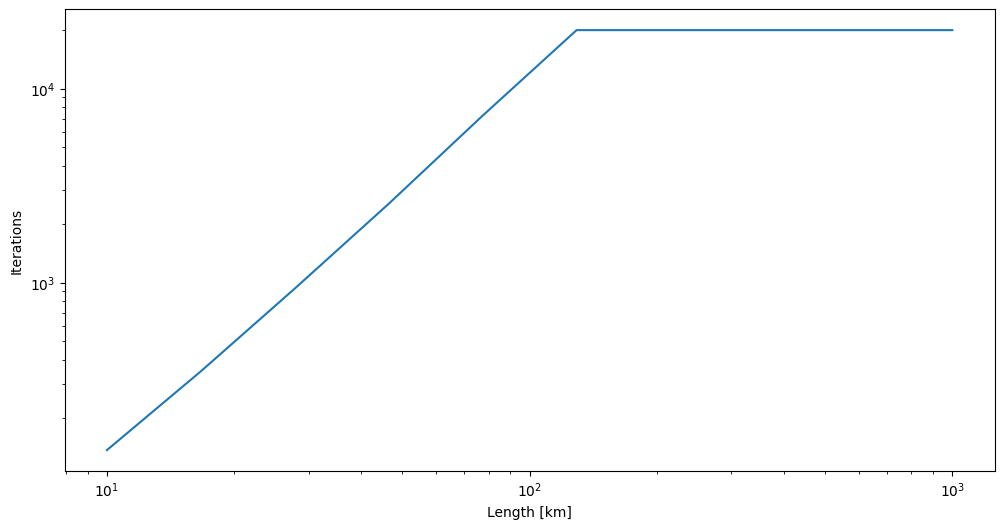

In [10]:
plt.plot(np.logspace(1, 3, 10), iterations)
plt.xlabel("Length [km]")
plt.ylabel("Iterations")
plt.xscale("log")
plt.yscale("log")

In [11]:
#OPTUNA Installation cell required to run notebook in different environments and kernels

In [12]:
%pip install optuna
%pip install --upgrade jupyter jupyterlab notebook


/home/a/a270285/.conda/envs/NaomiKernel/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [13]:
### OPTUNA AND TASK 1&2 First Try

### How to vary phases and vary A(s)

In [14]:
# === Cell 1: Optuna objective with Tasks 1&2 (fixed 8 phases, FAST) ===
import gc, time, optuna
from optuna.pruners import MedianPruner
import torch
import torch.nn.functional as F

def _free_cuda():
    torch.cuda.empty_cache(); gc.collect()

def _dtype_from_name(name: str):
    return torch.float64 if "64" in name else torch.float32

# Choose GROWTH
_GROWTH_E = 1.06
_GROWTH_M = 1.06
_GROWTH_B = 1.06

# Choose PHASES and EPOCHS and _AS_SUBSET for variaton
# NOT included in hyperparameter tuning, as significant computation time increase for non-guaranteed speed-up
# each phase trains on the first _AS_SUBSET graphs; set _AS_SUBSET = len(As) to use all graphs each phase
_AS_SUBSET = 2
_MAX_PHASES = 2         
_CAP_EPOCHS = 200         
_CAP_M      = 80        
_CAP_BATCH  = 4          


def objective(trial: optuna.Trial):
    # Vary ALL
    num_layers_          = trial.suggest_int("num_layers", 4, 16, step=2)
    embed_               = trial.suggest_categorical("embed", [16, 32, 48, 64])
    hidden_              = trial.suggest_categorical("hidden", [64, 96, 128, 192, 256])
    drop_rate_           = trial.suggest_float("drop_rate", 0.0, 0.4, step=0.05)
    disable_scale_input_ = trial.suggest_categorical("disable_scale_input", [False, True])
    dtype_name_          = trial.suggest_categorical("dtype", ["float32", "float64"])
    lr_                  = trial.suggest_float("lr", 5e-4, 5e-3, log=True)
    weight_decay_        = trial.suggest_float("weight_decay", 0.0, 1e-2, log=False)  # allow exact 0
    training_data_       = trial.suggest_categorical("training_data", ["x_mix", "x_subspace", "x_random"])
    m_                   = trial.suggest_int("m", 20, 80, step=10)
    batch_size_          = trial.suggest_categorical("batch_size", [1, 2, 4])
    grad_accu_steps_     = trial.suggest_categorical("grad_accu_steps", [1, 2, 4])
    epochs_              = trial.suggest_int("epochs", 60, 200)  # serves as BASE epochs
    phases_              = trial.suggest_int("phases", 1, _MAX_PHASES)
    dtype_ = _dtype_from_name(dtype_name_)

    # keep float64 trials lighter (CHATGPT)
    if dtype_ == torch.float64:
        m_ = min(m_, 40)
        batch_size_ = min(batch_size_, 2)

    # build model once in the sampled dtype; init on smallest graph
    A0 = As[0]
    net = ResGCN(
        A0,
        num_layers=num_layers_, embed=embed_, hidden=hidden_,
        drop_rate=drop_rate_, scale_input=(not disable_scale_input_), dtype=dtype_
    ).to(device).to(dtype_)

    optimizer = torch.optim.AdamW(net.parameters(), lr=lr_, weight_decay=weight_decay_)

    M_tune = GNP(A0, training_data_, m_, net, device)
    if hasattr(M_tune, "dtype"):
        M_tune.dtype = dtype_

    best_overall = float("inf")
    pruner_step = 0

    try:
        # Tasks 1&2: vary phases and subsets, each phase varies over _AS_SUBSET=K graphs which can be changed 
        total_phases = _MAX_PHASES
        As_fast = As[:min(_AS_SUBSET, len(As))]

        for phase in range(total_phases):
            # per-phase growth from the *trial* bases, then clamp to caps
            epochs_now = int(round(epochs_     * (_GROWTH_E ** phase)))
            m_now      = int(round(m_          * (_GROWTH_M ** phase)))
            batch_now  = int(round(batch_size_ * (_GROWTH_B ** phase)))

            epochs_now = max(1, min(_CAP_EPOCHS, epochs_now))
            M_tune.m   = max(1, min(_CAP_M,     m_now))
            batch_now  = max(1, min(_CAP_BATCH, batch_now))

            for i, Ai in enumerate(As_fast):
                M_tune.A = Ai

                # no checkpointing during search to keep trials light
                hist_loss, best_loss, best_epoch, _ = M_tune.train(
                    batch_size=batch_now,
                    grad_accu_steps=grad_accu_steps_,
                    epochs=epochs_now,
                    optimizer=optimizer,
                    scheduler=None,
                    num_workers=0,
                    checkpoint_prefix_with_path=None,
                    progress_bar=False,
                )

                metric = float(best_loss) if len(hist_loss) else float('inf')
                best_overall = min(best_overall, metric)

                pruner_step += 1
                trial.report(metric, pruner_step)
                if trial.should_prune():
                    raise optuna.exceptions.TrialPruned()

        return best_overall

    except RuntimeError as e:
        if "CUDA out of memory" in str(e):
            _free_cuda()
            raise optuna.exceptions.TrialPruned() from e
        raise
    finally:
        del net, optimizer, M_tune
        _free_cuda()


In [15]:
# Cell 2: Study setup (safe seeding) + globals update (+schedule) 
sampler = optuna.samplers.TPESampler(n_startup_trials=10, multivariate=True, group=True)
pruner  = MedianPruner(n_warmup_steps=2)

study = optuna.create_study(
    study_name="gnp_hparam_search",
    direction="minimize",
    sampler=sampler,
    pruner=pruner,
    # storage="sqlite:///gnp_optuna.db", load_if_exists=True,
)

# SAFE SEED VALUES (use existing if present, else defaults) 
seed_epochs = int(min(120, int(globals().get("_CAP_EPOCHS", 200))))
seed_phases = int(globals().get(1, _MAX_PHASES))

# seed with current globals + safe schedule seeds
study.enqueue_trial({
    "num_layers": num_layers,
    "embed": embed,
    "hidden": hidden,
    "drop_rate": drop_rate,
    "disable_scale_input": disable_scale_input,
    "dtype": "float64" if dtype == torch.float64 else "float32",
    "lr": lr,
    "weight_decay": weight_decay,
    "training_data": training_data,
    "m": m,
    "batch_size": batch_size,
    "grad_accu_steps": grad_accu_steps,
    "epochs": seed_epochs,  
    "phases": seed_phases,  
})

# choose amount of trials
study.optimize(objective, n_trials=12, gc_after_trial=True, show_progress_bar=True)

print(f"\n[Optuna] Trials: {len(study.trials)}  Best value: {study.best_value:.6e}")
print("[Optuna] Best hyperparameters:")
for k, v in study.best_trial.params.items():
    print(f"  {k}: {v}")

best = study.best_trial.params

# Update core 
num_layers = int(best["num_layers"])
embed = int(best["embed"])
hidden = int(best["hidden"])
drop_rate = float(best["drop_rate"])
disable_scale_input = bool(best["disable_scale_input"])
dtype = torch.float64 if best["dtype"] == "float64" else torch.float32
lr = float(best["lr"])
weight_decay = float(best["weight_decay"])
training_data = str(best["training_data"])
m = int(best["m"])
batch_size = int(best["batch_size"])
grad_accu_steps = int(best["grad_accu_steps"])

# Export schedule knobs for the training cell
# Use tuned 'epochs' and 'phases' if present; otherwise keep the seed values.
PHASES = int(best.get("phases", seed_phases))
EPOCHS_PER_PHASE_BASE = int(best.get("epochs", seed_epochs))
M_BASE = int(best.get("m", m))
BATCH_BASE = int(best.get("batch_size", batch_size))

# Keep these consistent with Cell 1 FAST settings:
GROWTH_EPOCHS = 1.06
GROWTH_M = 1.06
GROWTH_BATCH = 1.06
MAX_EPOCHS_PER_PHASE = 40
MAX_M = 512
MAX_BATCH = 4

# Runtime knobs used by the training cell
CKPT_DIR = "./checkpoints_tasks12"
SAVE_BEST_EACH_PASS = True
RESUME_FROM_PHASE = 0

print("\n[Optuna] Globals updated (+schedule).")
print(f"[Schedule] PHASES={PHASES}, EPOCHS_BASE={EPOCHS_PER_PHASE_BASE}, "
      f"M_BASE={M_BASE}, BATCH_BASE={BATCH_BASE}, "
      f"GROWTH(E,M,B)=({GROWTH_EPOCHS},{GROWTH_M},{GROWTH_BATCH}), "
      f"MAX(E,M,B)=({MAX_EPOCHS_PER_PHASE},{MAX_M},{MAX_BATCH})")



/home/a/a270285/.conda/envs/NaomiKernel/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/a/a270285/.conda/envs/NaomiKernel/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-10-24 09:08:44,609] A new study created in memory with name: gnp_hparam_search


  0%|          | 0/12 [00:00<?, ?it/s]

[I 2025-10-24 09:09:17,198] Trial 0 finished with value: 0.012769345880327392 and parameters: {'num_layers': 8, 'embed': 32, 'hidden': 64, 'drop_rate': 0.05, 'disable_scale_input': False, 'dtype': 'float64', 'lr': 0.002, 'weight_decay': 0.0, 'training_data': 'x_mix', 'm': 80, 'batch_size': 4, 'grad_accu_steps': 1, 'epochs': 120, 'phases': 2}. Best is trial 0 with value: 0.012769345880327392.
[I 2025-10-24 09:10:40,917] Trial 1 finished with value: 0.00616437764188655 and parameters: {'num_layers': 16, 'embed': 48, 'hidden': 64, 'drop_rate': 0.30000000000000004, 'disable_scale_input': True, 'dtype': 'float64', 'lr': 0.0008672572464881303, 'weight_decay': 0.0015880300297792982, 'training_data': 'x_subspace', 'm': 60, 'batch_size': 4, 'grad_accu_steps': 2, 'epochs': 143, 'phases': 2}. Best is trial 1 with value: 0.00616437764188655.
[I 2025-10-24 09:11:06,853] Trial 2 finished with value: 0.013107389947351647 and parameters: {'num_layers': 6, 'embed': 48, 'hidden': 192, 'drop_rate': 0.0, 

In [16]:
# Final Tasks 1&2 training (uses globals set by Optuna Cell 2) 
import os, time, gc, numpy as np, torch

# minimal sanity
assert 'As' in globals() and len(As) > 0
assert 'ResGCN' in globals() and 'GNP' in globals()
assert 'device' in globals()

# build model
net = ResGCN(
    As[0], num_layers, embed, hidden, drop_rate,
    scale_input=(not disable_scale_input), dtype=dtype
).to(device).to(dtype)

optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = None

M = GNP(As[0], training_data, M_BASE, net, device)
if hasattr(M, "dtype"): M.dtype = dtype

os.makedirs(CKPT_DIR, exist_ok=True)
NUM_WORKERS = 0

t0 = time.time()
for phase in range(RESUME_FROM_PHASE, PHASES):
    # per-phase growth 
    epochs_now = int(max(1, min(MAX_EPOCHS_PER_PHASE, round(EPOCHS_PER_PHASE_BASE * (GROWTH_EPOCHS ** phase)))))
    M.m        = int(max(1, min(MAX_M,                round(M_BASE                * (GROWTH_M      ** phase)))))
    batch_now  = int(max(1, min(MAX_BATCH,            round(BATCH_BASE            * (GROWTH_BATCH  ** phase)))))

    print(f"\n=== PHASE {phase+1}/{PHASES} === [epochs={epochs_now}, batch={batch_now}, m={M.m}]")
    tic = time.time()

    for i, Ai in enumerate(As):
        gc.collect()
        M.A = Ai  # <-- refresh graph for this pass
        ckpt_prefix = os.path.join(CKPT_DIR, f"p{phase:04d}_Ai{i:03d}_")

        hist_loss, best_loss, best_epoch, model_file = M.train(
            batch_now, grad_accu_steps, epochs_now,
            optimizer, scheduler,
            num_workers=NUM_WORKERS,
            checkpoint_prefix_with_path=(ckpt_prefix if SAVE_BEST_EACH_PASS else None),
            progress_bar=False
        )

        # optional reload of best
        if SAVE_BEST_EACH_PASS:
            candidates = []
            if model_file: candidates.append(model_file)
            candidates += [f"{ckpt_prefix}epoch_{best_epoch}.pt", f"{ckpt_prefix}best.pt"]
            for wpath in candidates:
                if wpath and os.path.exists(wpath):
                    try:
                        state = torch.load(wpath, map_location=device, weights_only=True)
                    except TypeError:
                        state = torch.load(wpath, map_location=device)
                    if isinstance(M.net, torch.nn.Module):
                        M.net.load_state_dict(state)
                    break

        try:
            init_loss, final_loss = float(hist_loss[0]), float(hist_loss[-1])
        except Exception:
            init_loss = final_loss = np.nan
        print(f"  Ai {i:03d} | init={init_loss:.4e}, final={final_loss:.4e}, best={float(best_loss):.4e}@{best_epoch}")
        del hist_loss, best_loss, best_epoch, model_file

    torch.save(M.net.state_dict(), os.path.join(CKPT_DIR, f"phase_{phase:04d}_end.pt"))
    print(f"[phase {phase+1}] {time.time()-tic:.2f}s")

print(f"\n[Tasks 1+2] Completed in {time.time()-t0:.2f}s.")



=== PHASE 1/1 === [epochs=40, batch=2, m=60]
  Ai 000 | init=1.0631e-02, final=8.2744e-03, best=7.7114e-03@31
  Ai 001 | init=9.6812e-03, final=5.6173e-03, best=5.4186e-03@37
  Ai 002 | init=6.2588e-03, final=4.6415e-03, best=4.6415e-03@39
  Ai 003 | init=4.9609e-03, final=5.0171e-03, best=4.0183e-03@29
  Ai 004 | init=7.3124e-03, final=4.5261e-03, best=3.9988e-03@38
  Ai 005 | init=4.5321e-03, final=5.1175e-03, best=3.7516e-03@29
  Ai 006 | init=4.8187e-03, final=5.0287e-03, best=3.5853e-03@18
  Ai 007 | init=3.6070e-03, final=4.3517e-03, best=3.6070e-03@0
  Ai 008 | init=4.7813e-03, final=5.5756e-03, best=3.4132e-03@16
  Ai 009 | init=3.6854e-03, final=5.6137e-03, best=3.5022e-03@20
[phase 1] 59.46s

[Tasks 1+2] Completed in 59.46s.



=== PHASE 1/1 === [epochs=40, batch=2, m=60]
  Ai 000 | init=1.3314e-02, final=9.9258e-03, best=8.8195e-03@37
  Ai 001 | init=1.0143e-02, final=7.4251e-03, best=6.8372e-03@31
  Ai 002 | init=7.6680e-03, final=5.9278e-03, best=5.1330e-03@32
  Ai 003 | init=5.9206e-03, final=4.5300e-03, best=4.5300e-03@39
  Ai 004 | init=4.9387e-03, final=5.8389e-03, best=4.1520e-03@27
  Ai 005 | init=6.3180e-03, final=4.0212e-03, best=3.8736e-03@30
  Ai 006 | init=3.9901e-03, final=4.1114e-03, best=3.6176e-03@3
  Ai 007 | init=5.5258e-03, final=4.7934e-03, best=3.8311e-03@33
  Ai 008 | init=4.5692e-03, final=4.7545e-03, best=3.7888e-03@11
  Ai 009 | init=4.6657e-03, final=5.1207e-03, best=3.4453e-03@21
[phase 1] 59.52s

[Tasks 1+2] Completed in 59.52s.


Solve: 100%|██████████| 2000/2000 [01:08<00:00, 29.40it/s]


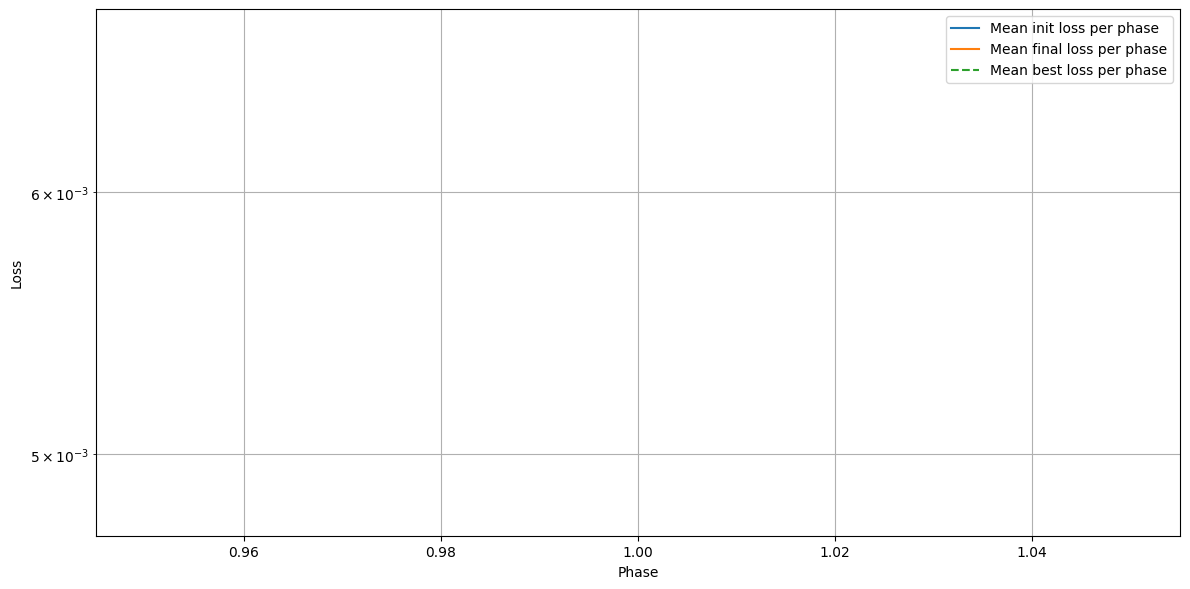

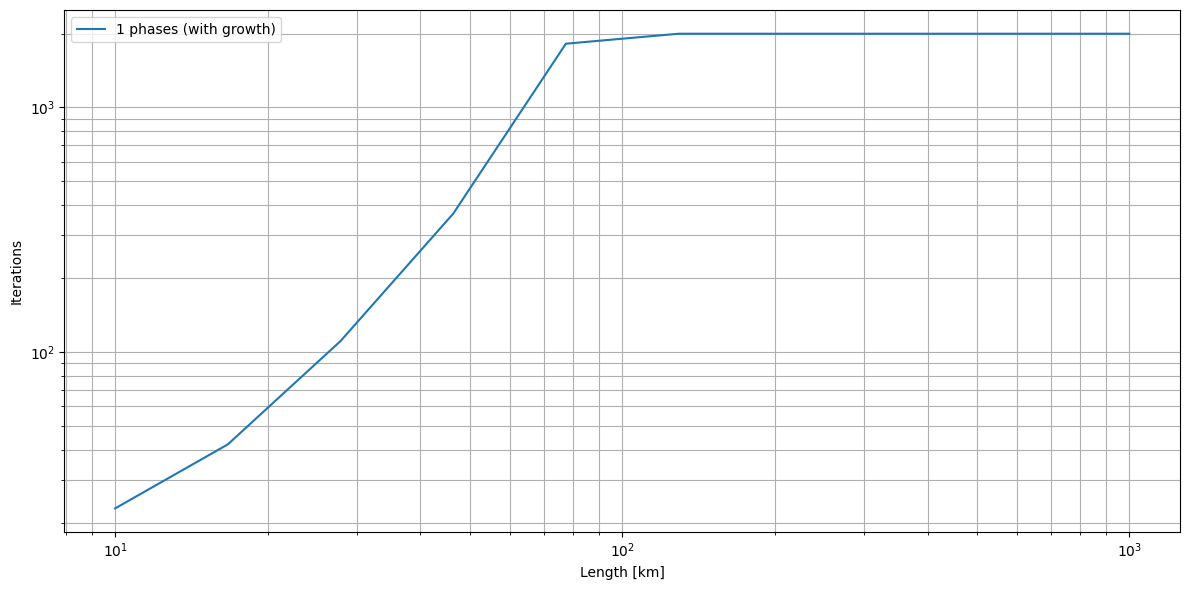

In [17]:
# Final Tasks 1&2 training (uses globals set by Optuna Cell 2) + logging + plots
import os, time, gc, numpy as np, torch
import matplotlib.pyplot as plt

# minimal sanity
assert 'As' in globals() and len(As) > 0
assert 'ResGCN' in globals() and 'GNP' in globals()
assert 'device' in globals()

# build model
net = ResGCN(
    As[0], num_layers, embed, hidden, drop_rate,
    scale_input=(not disable_scale_input), dtype=dtype
).to(device).to(dtype)

optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = None

M = GNP(As[0], training_data, M_BASE, net, device)
if hasattr(M, "dtype"): 
    M.dtype = dtype

os.makedirs(CKPT_DIR, exist_ok=True)
NUM_WORKERS = 0

# --- accumulators for learning curve (mean over As) ---
phase_mean_init  = []
phase_mean_final = []
phase_mean_best  = []
phase_best_epoch = []

t0 = time.time()
for phase in range(RESUME_FROM_PHASE, PHASES):
    # per-phase growth 
    epochs_now = int(max(1, min(MAX_EPOCHS_PER_PHASE, round(EPOCHS_PER_PHASE_BASE * (GROWTH_EPOCHS ** phase)))))
    M.m        = int(max(1, min(MAX_M,                round(M_BASE                * (GROWTH_M      ** phase)))))
    batch_now  = int(max(1, min(MAX_BATCH,            round(BATCH_BASE            * (GROWTH_BATCH  ** phase)))))

    print(f"\n=== PHASE {phase+1}/{PHASES} === [epochs={epochs_now}, batch={batch_now}, m={M.m}]")
    tic = time.time()

    # per-phase collectors (over As)
    inits_this_phase  = []
    finals_this_phase = []
    bests_this_phase  = []
    best_epochs_this  = []

    for i, Ai in enumerate(As):
        gc.collect()
        M.A = Ai  # refresh graph for this pass
        ckpt_prefix = os.path.join(CKPT_DIR, f"p{phase:04d}_Ai{i:03d}_")

        hist_loss, best_loss, best_epoch, model_file = M.train(
            batch_now, grad_accu_steps, epochs_now,
            optimizer, scheduler,
            num_workers=NUM_WORKERS,
            checkpoint_prefix_with_path=(ckpt_prefix if SAVE_BEST_EACH_PASS else None),
            progress_bar=False
        )

        # optional reload of best
        if SAVE_BEST_EACH_PASS:
            candidates = []
            if model_file: 
                candidates.append(model_file)
            candidates += [f"{ckpt_prefix}epoch_{best_epoch}.pt", f"{ckpt_prefix}best.pt"]
            for wpath in candidates:
                if wpath and os.path.exists(wpath):
                    try:
                        state = torch.load(wpath, map_location=device, weights_only=True)
                    except TypeError:
                        state = torch.load(wpath, map_location=device)
                    if isinstance(M.net, torch.nn.Module):
                        M.net.load_state_dict(state)
                    break

        # losses for logging
        try:
            init_loss, final_loss = float(hist_loss[0]), float(hist_loss[-1])
        except Exception:
            init_loss = final_loss = np.nan

        inits_this_phase.append(init_loss)
        finals_this_phase.append(final_loss)
        bests_this_phase.append(float(best_loss))
        best_epochs_this.append(int(best_epoch))

        print(f"  Ai {i:03d} | init={init_loss:.4e}, final={final_loss:.4e}, best={float(best_loss):.4e}@{best_epoch}")
        del hist_loss, best_loss, best_epoch, model_file

    # store per-phase means (robust to NaNs)
    phase_mean_init.append(np.nanmean(inits_this_phase)   if inits_this_phase   else np.nan)
    phase_mean_final.append(np.nanmean(finals_this_phase) if finals_this_phase  else np.nan)
    phase_mean_best.append(np.nanmean(bests_this_phase)   if bests_this_phase   else np.nan)
    phase_best_epoch.append(int(np.nanmean(best_epochs_this)) if best_epochs_this else 0)

    torch.save(M.net.state_dict(), os.path.join(CKPT_DIR, f"phase_{phase:04d}_end.pt"))
    print(f"[phase {phase+1}] {time.time()-tic:.2f}s")

print(f"\n[Tasks 1+2] Completed in {time.time()-t0:.2f}s.")

# =========================
# PLOTS (learning curve + iterations vs length)
# =========================

# --- Learning curve over phases (mean losses across As) ---
phases_axis = np.arange(len(phase_mean_final)) + 1  # 1..PHASES

plt.figure()
plt.plot(phases_axis, phase_mean_init,  label="Mean init loss per phase")
plt.plot(phases_axis, phase_mean_final, label="Mean final loss per phase")
plt.plot(phases_axis, phase_mean_best,  label="Mean best loss per phase", linestyle="--")
plt.xlabel("Phase")
plt.ylabel("Loss")
plt.yscale("log")
plt.grid(True, which="both")
plt.legend()
plt.tight_layout()

# --- Iterations vs length (recompute with the trained M) ---
iterations_tasks12 = np.zeros(len(As), dtype=float)
for i, Ai in enumerate(As):
    M.A = Ai  # ensure M uses the current graph
    ttw = data - Ai @ data
    # keep progress silent for clean output
    x, iters, *_ = solver.solve(A=Ai, b=ttw, rtol=1e-6, max_iters=2000, progress_bar=True, M=M)
    iterations_tasks12[i] = iters

# x-axis: same count as As
x_lengths = np.logspace(1, 3, len(As))

plt.figure()
plt.plot(x_lengths, iterations_tasks12, label=f"{PHASES} phases (with growth)")
plt.xlabel("Length [km]")
plt.ylabel("Iterations")
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which="both")
plt.legend()
plt.tight_layout()


In [23]:
# Unified config: Tasks 1 + 2 + 3 



num_layers = 8              # number of layers in GNP
embed = 32                  # embedding dimension in GNP
hidden = 64                 # hidden dimension in MLPs in GNP
drop_rate = 0.05            # dropout rate in GNP
disable_scale_input = False # whether disable the scaling of inputs in GNP
dtype = torch.float64       # training precision for GNP
lr = 2e-3                   # learning rate in training GNP
weight_decay = 0.0          # weight decay in training GNP
training_data = 'x_mix'     # type of training data x
m = 40                      # Krylov subspace dimension for training data
batch_size = 4              # batch size in training GNP
grad_accu_steps = 1         # gradient accumulation steps in training GNP
epochs = 1000               # number of epochs in training GNP 


# Total number of phases (Task 2)
PHASES = 3

# Task 1: growth starting points
EPOCHS_PER_PHASE_BASE = 2     
M_BASE                = m     
BATCH_BASE            = batch_size

# Growth factors per phase (Task 1)
GROWTH_EPOCHS = 1.15
GROWTH_M      = 1.10
GROWTH_BATCH  = 1.20

# Caps (safety)
MAX_EPOCHS_PER_PHASE = 10
MAX_M                = M_BASE * 8
MAX_BATCH            = BATCH_BASE * 8

# Task 3: loopbacks
LOOPBACK_EVERY = 5    # after every 5 phases, run a loopback sweep
LOOPBACK_EPOCHS = 1   # tiny number of epochs during loopback

# Courtesy to ChatGPT for Checkpointing
CKPT_DIR = "./ckpt_unified/"
SAVE_BEST_EACH_PASS = True
RESUME_FROM_PHASE = 0

print(f"[Unified Config] PHASES={PHASES}, start epochs={EPOCHS_PER_PHASE_BASE}, m={M_BASE}, batch={BATCH_BASE}")
print(f"[Growth] g_epochs={GROWTH_EPOCHS}, g_m={GROWTH_M}, g_batch={GROWTH_BATCH}")
print(f"[Loopback] every {LOOPBACK_EVERY} phases, epochs/ai={LOOPBACK_EPOCHS}")


[Unified Config] PHASES=3, start epochs=2, m=40, batch=4
[Growth] g_epochs=1.15, g_m=1.1, g_batch=1.2
[Loopback] every 5 phases, epochs/ai=1


In [24]:
# Unified training loop: Tasks 1+2+3 (growth + many phases + loopbacks) 
import os, time, torch, numpy as np

assert 'As' in globals() and isinstance(As, list) and len(As) > 0
assert 'data' in globals()
assert 'solver' in globals()

net = ResGCN(
    As[0], num_layers, embed, hidden, drop_rate,
    scale_input=(not disable_scale_input), dtype=dtype
).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = None

M = GNP(As[0], training_data, M_BASE, net, device)

os.makedirs(CKPT_DIR, exist_ok=True)
NUM_WORKERS = 0

def train_subset(A_list, epochs_per_ai, phase_tag, batch_now, m_now):
    """Train sequentially on a list of As with given epochs/batch/m."""
    M.m = m_now
    for i, Ai in enumerate(A_list):
        # Call garbage collector and free whatever cache there is
        # IDK why but seems to work
        # torch.cuda.empty_cache()
        gc.collect()
        M.A = Ai
        ckpt_prefix = os.path.join(CKPT_DIR, f"{phase_tag}_Ai{i:03d}_")
        hist_loss, best_loss, best_epoch, model_file = M.train(
            batch_now, grad_accu_steps, epochs_per_ai,
            optimizer, scheduler,
            num_workers=NUM_WORKERS,
            checkpoint_prefix_with_path=ckpt_prefix if SAVE_BEST_EACH_PASS else None,
            progress_bar=False
        )
        if SAVE_BEST_EACH_PASS:
            candidates = []
            if model_file: candidates.append(model_file)
            candidates += [f"{ckpt_prefix}epoch_{best_epoch}.pt", f"{ckpt_prefix}best.pt"]
            for wpath in candidates:
                if os.path.exists(wpath):
                    try:
                        state = torch.load(wpath, map_location=device, weights_only=True)
                    except TypeError:
                        state = torch.load(wpath, map_location=device)
                    M.net.load_state_dict(state)
                    break
        
        try:
            init_loss = float(hist_loss[0]); final_loss = float(hist_loss[-1])
        except Exception:
            init_loss, final_loss = np.nan, np.nan
        print(f"      Ai | init={init_loss:.4e}, final={final_loss:.4e}, best={best_loss:.4e} @ epoch {best_epoch}")
        # Explicitly delete variables created in the loop
        # Should happen on its own, but it doesn't
        del hist_loss, best_loss, best_epoch, model_file

# Training across all phases 
t0_all = time.time()
for phase in range(RESUME_FROM_PHASE, PHASES):
    # Task 1 growth (scaled with phase index)
    epochs_now = int(max(1, min(MAX_EPOCHS_PER_PHASE, round(EPOCHS_PER_PHASE_BASE * (GROWTH_EPOCHS ** phase)))))
    m_now      = int(max(1, min(MAX_M,                round(M_BASE                * (GROWTH_M      ** phase)))))
    batch_now  = int(max(1, min(MAX_BATCH,            round(BATCH_BASE            * (GROWTH_BATCH  ** phase)))))

    print(f"\n=== Phase {phase+1}/{PHASES} === [epochs/ai={epochs_now}, batch={batch_now}, m={m_now}]")
    tic_phase = time.time()
    train_subset(As, epochs_now, phase_tag=f"p{phase:04d}", batch_now=batch_now, m_now=m_now)
    print(f"[phase {phase+1}] done in {time.time() - tic_phase:.2f} s")

    # Task 3 loopback: after every LOOPBACK_EVERY phases
    if (phase + 1) % LOOPBACK_EVERY == 0:
        print(f"   >> Loopback after phase {phase+1} (epochs/ai={LOOPBACK_EPOCHS})")
        tic_lb = time.time()
        train_subset(As, LOOPBACK_EPOCHS, phase_tag=f"loopback_p{phase:04d}", batch_now=batch_now, m_now=m_now)
        print(f"   Loopback time: {time.time() - tic_lb:.2f} s")

    torch.save(M.net.state_dict(), os.path.join(CKPT_DIR, f"phase_{phase:04d}_end.pt"))

print(f"\n[Unified Training] Completed {PHASES} phases in {time.time() - t0_all:.2f} s.")



=== Phase 1/3 === [epochs/ai=2, batch=4, m=40]
      Ai | init=1.0178e-01, final=1.0203e-01, best=1.0178e-01 @ epoch 0
      Ai | init=1.0039e-01, final=1.0102e-01, best=1.0039e-01 @ epoch 0
      Ai | init=1.0027e-01, final=9.9929e-02, best=9.9929e-02 @ epoch 1
      Ai | init=1.0023e-01, final=9.8850e-02, best=9.8850e-02 @ epoch 1
      Ai | init=9.9575e-02, final=9.7808e-02, best=9.7808e-02 @ epoch 1
      Ai | init=9.8014e-02, final=9.6549e-02, best=9.6549e-02 @ epoch 1
      Ai | init=9.6605e-02, final=9.3154e-02, best=9.3154e-02 @ epoch 1
      Ai | init=9.3840e-02, final=9.0933e-02, best=9.0933e-02 @ epoch 1
      Ai | init=9.0490e-02, final=8.7075e-02, best=8.7075e-02 @ epoch 1
      Ai | init=8.7517e-02, final=8.1852e-02, best=8.1852e-02 @ epoch 1
[phase 1] done in 7.34 s

=== Phase 2/3 === [epochs/ai=2, batch=5, m=44]
      Ai | init=9.8361e-02, final=9.1652e-02, best=9.1652e-02 @ epoch 1
      Ai | init=9.1018e-02, final=8.3820e-02, best=8.3820e-02 @ epoch 1
      Ai | init


Solve:   2%|▏         | 47/2000 [00:00<00:37, 52.56it/s]

Solve:   4%|▍         | 89/2000 [00:01<00:35, 53.15it/s]

Solve:  10%|▉         | 195/2000 [00:03<00:33, 53.43it/s]

Solve:  26%|██▌       | 516/2000 [00:09<00:27, 53.57it/s]

Solve:  77%|███████▋  | 1531/2000 [00:28<00:08, 53.55it/s]

Solve: 100%|██████████| 2000/2000 [00:37<00:00, 53.54it/s]

Solve: 100%|██████████| 2000/2000 [00:37<00:00, 53.58it/s]

Solve: 100%|██████████| 2000/2000 [00:37<00:00, 53.55it/s]

Solve: 100%|██████████| 2000/2000 [00:37<00:00, 53.56it/s]

Solve: 100%|██████████| 2000/2000 [00:37<00:00, 53.54it/s]


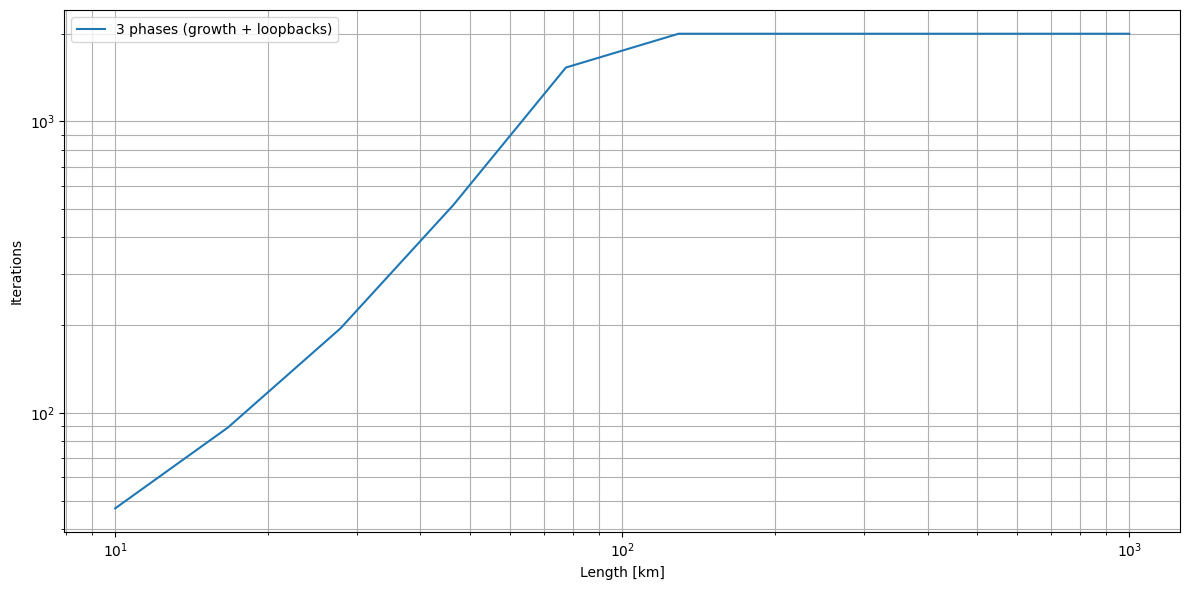

In [26]:
iterations_unified = np.zeros(len(As))
for i, Ai in enumerate(As):
    ttw = data - Ai @ data
    x, iters, *_ = solver.solve(A=Ai, b=ttw, rtol=1e-6, max_iters=2000, progress_bar=True, M=M)
    iterations_unified[i] = iters

plt.figure()
plt.plot(np.logspace(1, 3, 10), iterations_unified, label=f"{PHASES} phases (growth + loopbacks)")

plt.xlabel("Length [km]")
plt.ylabel("Iterations")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both")
plt.tight_layout()


In [ ]:
### Condition Number Plot ###

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import IterableDataset
from torch.utils.data.dataloader import DataLoader
import os
import numpy as np
from tqdm import tqdm

def scale_A_by_spectral_radius(A):

    if A.layout == torch.sparse_csc:

        absA = torch.absolute(A)
        m, n = absA.shape
        row_sum = absA @ torch.ones(n, 1, dtype=A.dtype, device=A.device)
        col_sum = torch.ones(1, m, dtype=A.dtype, device=A.device) @ absA
        gamma = torch.min(torch.max(row_sum), torch.max(col_sum))
        outA = A * (1. / gamma.item())

    elif A.layout == torch.strided:

        absA = torch.absolute(A)
        row_sum = torch.sum(absA, dim=1)
        col_sum = torch.sum(absA, dim=0)
        gamma = torch.min(torch.max(row_sum), torch.max(col_sum))
        outA = A / gamma

    else:

        raise NotImplementedError(
            'A must be either torch.sparse_csc_tensor or torch.tensor')

    return outA


class Arnoldi():
    def build(self, A, v0=None, m=100):

        n = A.shape[0]
        if v0 is None:
            v0 = torch.normal(0, 1, size=(n,), dtype=A.dtype).to(A.device)
        beta = torch.linalg.norm(v0)

        V = torch.zeros(n, m + 1, dtype=A.dtype).to(A.device)
        H = torch.zeros(m + 1, m, dtype=A.dtype).to(A.device)

        V[:, 0] = v0 / beta
        for j in range(m):
            w = A @ V[:, j]
            for k in range(j + 1):
                H[k, j] = torch.dot(V[:, k], w)
                w = w - H[k, j] * V[:, k]
            H[j + 1, j] = torch.linalg.norm(w)
            V[:, j + 1] = w / H[j + 1, j]

        Vm1 = V
        barHm = H
        return Vm1, barHm


# The following class implements a streaming dataset, which, in combined use with the dataloader, produces x of size (n,batch_size). x is float64 and stays in cpu. It will be moved to the 
# device and cast to a lower precision for training.
class StreamingDataset(IterableDataset):

    # A is torch tensor, either sparse or full
    def __init__(self, A, batch_size, training_data, m):
        super().__init__()
        self.n = A.shape[0]
        self.m = m
        self.batch_size = batch_size
        self.training_data = training_data

        # Computations done in device
        if training_data == 'x_subspace' or training_data == 'x_mix':
            arnoldi = Arnoldi()
            Vm1, barHm = arnoldi.build(A, m=m)
            W, S, Zh = torch.linalg.svd(barHm, full_matrices=False)
            Q = (Vm1[:, :-1] @ Zh.T) / S.view(1, m)
            self.Q = Q.to('cpu')

    def generate(self):
        while True:

            # Computation done in cpu
            if self.training_data == 'x_normal':

                x = torch.normal(0, 1, size=(self.n, self.batch_size),
                                 dtype=torch.float64)
                yield x

            elif self.training_data == 'x_subspace':

                e = torch.normal(0, 1, size=(self.m, self.batch_size),
                                 dtype=torch.float64)
                x = self.Q @ e
                yield x

            elif self.training_data == 'x_mix':

                batch_size1 = self.batch_size // 2
                e = torch.normal(0, 1, size=(self.m, batch_size1),
                                 dtype=torch.float64)
                x = self.Q @ e
                batch_size2 = self.batch_size - batch_size1
                x2 = torch.normal(0, 1, size=(self.n, batch_size2),
                                  dtype=torch.float64)
                x = torch.cat([x, x2], dim=1)
                yield x

            else:  # self.training_data == 'no_x'

                b = torch.normal(0, 1, size=(self.n, self.batch_size),
                                 dtype=torch.float64)
                yield b

    def __iter__(self):
        return iter(self.generate())


class GNP():

    # A is torch tensor, either sparse or full
    def __init__(self, A, training_data, m, net, device):
        self.A = A
        self.training_data = training_data
        self.m = m
        self.net = net
        self.device = device
        self.dtype = net.dtype

    def train(self, batch_size, grad_accu_steps, epochs, optimizer,
              scheduler=None, num_workers=0, checkpoint_prefix_with_path=None,
              progress_bar=True):

        self.net.train()
        optimizer.zero_grad()
        dataset = StreamingDataset(self.A, batch_size,
                                   self.training_data, self.m)
        loader = DataLoader(dataset, num_workers=num_workers, pin_memory=True)

        hist_loss = []
        best_loss = np.inf
        best_epoch = -1
        checkpoint_file = None

        if progress_bar:
            pbar = tqdm(total=epochs, desc='Train')

        for epoch, x_or_b in enumerate(loader):

            # Generate training data
            if self.training_data != 'no_x':
                x = x_or_b[0].to(self.device)
                b = self.A @ x
                b, x = b.to(self.dtype), x.to(self.dtype)
            else:  # self.training_data == 'no_x'
                b = x_or_b[0].to(self.device).to(self.dtype)

            # Train
            x_out = self.net(b)
            b_out = (self.A @ x_out.to(torch.float64)).to(self.dtype)
            loss = F.l1_loss(b_out, b)

            # Bookkeeping
            hist_loss.append(loss.item())
            if loss.item() < best_loss:
                best_loss = loss.item()
                best_epoch = epoch
                if checkpoint_prefix_with_path is not None:
                    checkpoint_file = checkpoint_prefix_with_path + 'best.pt'
                    torch.save(self.net.state_dict(), checkpoint_file)

            # Train (cont.)
            loss.backward()
            if (epoch + 1) % grad_accu_steps == 0 or epoch == epochs - 1:
                optimizer.step()
                optimizer.zero_grad()
                if scheduler is not None:
                    scheduler.step()

            # Bookkeeping (cont.)
            if progress_bar:
                pbar.set_description(f'Train loss {loss:.1e}')
                pbar.update()
            if epoch == epochs - 1:
                break

        # Bookkeeping (cont.)
        if checkpoint_file is not None:
            checkpoint_file_old = checkpoint_file
            checkpoint_file = \
                checkpoint_prefix_with_path + f'epoch_{best_epoch}.pt'
            os.rename(checkpoint_file_old, checkpoint_file)

        return hist_loss, best_loss, best_epoch, checkpoint_file

    @torch.no_grad()
    def apply(self, r):  # r: float64
        self.net.eval()
        # r = r.to(self.dtype)  # -> lower precision
        r = r.view(-1, 1)
        z = self.net(r)
        z = z.view(-1)
        # z = z.double()  # -> float64
        return z






import torch
import numpy as np
import matplotlib.pyplot as plt
import GNP

condition_numbers = []
epochs_tracked = []

dataset = StreamingDataset(A, batch_size=batch_size,
                           training_data=training_data, m=m)
loader = iter(torch.utils.data.DataLoader(dataset, num_workers=0, batch_size=None))

log_intervals = 20  
interval = 3000 // log_intervals

print("Tracking condition number during training evaluation...")

for i in range(log_intervals + 1):
    epoch = i * interval
    x_or_b = next(loader)

    if training_data != 'no_x':
        x = x_or_b.to(device)
        b = A @ x
        b, x = b.to(net.dtype), x.to(net.dtype)
    else:
        b = x_or_b.to(device).to(net.dtype)

    with torch.no_grad():
        x_out = net(b)

    try:
        ratio = torch.linalg.lstsq(x_out.double(), b.double()).solution
        cond = np.linalg.cond(ratio.cpu().numpy())
        condition_numbers.append(cond)
        epochs_tracked.append(epoch)
        print(f"Epoch {epoch:4d}: Condition number = {cond:.2e}")
    except Exception as e:
        print(f"Failed at epoch {epoch}: {e}")
        condition_numbers.append(np.nan)
        epochs_tracked.append(epoch)

plt.figure(figsize=(8, 5))
plt.plot(epochs_tracked, condition_numbers, marker='o')
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Estimated Condition Number")
plt.title("Condition Number Evolution During Training")
plt.grid(True, which='both')
plt.tight_layout()
plt.show()


In [ ]:
# improve preconditioned iterations lower

In [ ]:
# not during training, but maybe the condition number overall for a given matrix